Challenge 1

Success measure criterion --> Impact of service to increase restaurant's customers

Impact measure criterion:
    1. Compare sales before vs after picture posted
    3. Compare quality of home made pictures with pro pictures -- The gap has decreased due to improvements and availability of technology and free tutorials
    4. Since COVID more people order online --> Easier to sell food and then less need of high quality presentation? Or in the oder way higher standards?
    5. Evolution of maintenance cost for photografy service

Implementation:
    Global:
        For each year from 2001 to 2023: Number of subs to the service / Number of subscription to just eat --> Regression for the next X years
        Evolution of the overall deployment and maintenance cost of the service --> regression for the next X years
    Sample of restaurants divided by geographical criterion (maybe target, type of food):
        Ratings (stars) of the service   
        Percentage of sell increase with respect to before
    Sample of customers divided by geographical criterion, target, type of food:
        Percentage of orders coming from restaurant using photo service
        Importance of picture criterion with respect to cost, qaulity and service criterion

Avoid Bias by:
    Create balanced dataset -- Balance by geographical areas, by price range
    Normalization
    K-Folding??

    

Punto 2: Semplice RNN con dataset etichettato.

Etichettatura multipla --> Softmax come attivazione finale

0: “Both are the same”
1: “They differ”
2: “I don’t know”

Come gestire il fatto che lo stesso percorso possa essere etichettato in maniera differente da 2 o + persone? Devo trovare un criterio per scegliere quale etichetta tenere. (Qual'è l'etichetta con la percentuale maggiore sullo stesso percorso?)

Attenzione real e estimated routes no hanno per forza la stessa lunghezza

In [10]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/My\ Drive/cabify
# # with open("github_token.txt", "r") as f:
# #   token = f.read()
# #  ! git clone https://{token}@github.com/lorenzoooooo/cabify
# %cd cabify
# ! git pull

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import shutil
import random
import numpy as np

In [12]:
# #Load json to dataframe
# df = pd.read_json('challenge_dataset.json')
# print(f"df size:  {df.size}")

# #Print a sample of real and estimated route
# i=df.iloc[3]
# df_estimated = pd.DataFrame(i['estimated_route'], columns=['Lat','Long'])
# # print(df_estimated.size)
# df_real = pd.DataFrame(i['real_route'], columns=['Lat','Long'])
# # print(df_real.size)
# plt.plot(df_estimated['Lat'], df_estimated['Long'], color='b')
# plt.plot(df_real['Lat'], df_real['Long'], color='r')
# # plt.scatter(df_estimated['Lat'], df_estimated['Long'], color='b')
# # plt.scatter(df_real['Lat'], df_real['Long'], color='r')
# plt.title('Annotator: ' + str(i['annotator'])+'\n'+'Annotation: '+str(i['annotation']))
# plt.legend(['Estimated route','Real route'])

reflexions:
    1. Dataset samples have different sizes -- Input size is variable --> how to declare NN?
    2. Are points related temporally o spatially? RNN need equal temporal dependencies between samples. Otherwise can use Graph neural network.

Approccio con feed forward:
Layer iniziale deve avere dimensione ingresso -- Basic MLP are not fit to take variable input size, either introduce padding or cut to fized size

GNN/GCN approach: Can take variable graph sizes as input

The point is that I don't have single graph with label, but couple of graphs. I don't want to learn how to recognize the "ight" graph, I want to recognize if the graph differs


Feed forward attempt

In [13]:
# input_size=??
# number_of_features=2

In [14]:
# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()

#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(input_size, number_of_features )  # 5*5 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, input):
#         f1 = F.relu(self.fc1(input))
#         # Fully connected layer F6: (N, 120) Tensor input,
#         # and outputs a (N, 84) Tensor, it uses RELU activation function
#         f2 = F.relu(self.fc2(f1))
#         # Gaussian layer OUTPUT: (N, 84) Tensor input, and
#         # outputs a (N, 10) Tensor
#         output = self.fc3(f2)
#         return output


# net = Net()
# print(net)


Possible alternative approach: Convolutional network --> Generate images of routes with associated labels and learn to recognize. 5000 images to generate -- Expensive approach

Generate fixed size image dataset

In [15]:
# #Load dataset
# df = pd.read_json('challenge_dataset.json')

# # print(f'number of same routes annotations: {df[(df["annotation"]=="Both are the same")].shape[0]}')
# # print(f'number of different routes annotations: {df[(df["annotation"]=="They differ")].shape[0]}')

# #List containing final dataset composed of journey_id and annotation
# rows_to_keep = []

# #Check if same route has multiple rating and if the annotations are different choose the one who is more rated
# iter = df['journey_id'].unique()
# for i in iter: 
#     #Select all the rows regarding the same journey_id
#     mask=(df['journey_id']==i)
    
#     #If this journey_id is rated only once append the journey_id and annotation to list
#     if (df[mask].shape[0]==1):
#         rows_to_keep.append([df[mask]['journey_id'].values[0], df[mask]['annotation'].values[0],
#                              df[mask]['estimated_route'].values[0], df[mask]['real_route'].values[0]])
    
#     #Otherwise choose the more used annotation on this journey_id
#     else:
#         # Count the number of times an annotation appears
#         x=df[mask]
#         tmp=[]
#         tmp.append(x[(x['annotation']=="Both are the same")].shape[0])
#         tmp.append(x[(x['annotation']=="They differ")].shape[0])
#         tmp.append(x[(x['annotation']=="I don't know")].shape[0])
        
#         #Select the annotation with max occurences
#         # selected_label=max(tmp)
#         idx_selected_label = tmp.index(max(tmp))
        
#         # Map the index to the corresponding label
#         labels = ["Both are the same", "They differ", "I don't know"]
#         selected_label_value = labels[idx_selected_label]
        
#         # Filter rows that match the selected label and append to list
#         tmp_list=x[x['annotation'] == selected_label_value].iloc[0]
#         rows_to_keep.append([tmp_list.values[0], tmp_list.values[2], 
#                              tmp_list.values[3], tmp_list.values[4]])

# labels_path='labels.csv'
# final_df=pd.DataFrame(rows_to_keep, columns=['journey_id', 'annotation', 'estimated_route', 'real_route'])
# final_df.to_csv(labels_path, columns=['journey_id', 'annotation'], index=False)

In [16]:
# # Create directory to save images
# output_dir = 'route_images'
# os.makedirs(output_dir, exist_ok=True)

# # Turn interactive plotting off to not show every figure
# plt.ioff()

# #Create database of unique routes images 
# for _, df_sample in final_df.iterrows():      
#     df_estimated = pd.DataFrame(df_sample['estimated_route'], columns=['Lat','Long'])
#     df_real = pd.DataFrame(df_sample['real_route'], columns=['Lat','Long'])
    
#     fig = plt.figure(frameon=False)
#     # Set the figure size to be square (for example, 6x6 inches)
#     fig.set_size_inches(6, 6)
    
#     image_path = f'{output_dir}/{df_sample["journey_id"]}.png'
#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)

#     plt.plot(df_estimated['Lat'], df_estimated['Long'], color='c')
#     plt.plot(df_real['Lat'], df_real['Long'], color='r')
#     # plt.savefig(image_path, dpi=300, bbox_inches='tight') # Dimension = 1920*1440 pixels
#     plt.savefig(image_path, dpi=37, bbox_inches='tight')   # Dimension 224*224
#     # plt.savefig(image_path, dpi=5, bbox_inches='tight')   # Dimension 32*32
#     plt.close() 

# #Execution time - 6min39s for image Dimension = 1920*1440 pixels
# #Execution time - 1min30s for image Dimension = 224*224 pixels
# #Execution time - 31s for image Dimension = 32*32 pixels

Create dataset splitting in Train, Val and Test - Unbalanced
----Run only once, oherwise it adds to the dataset previously created ---

In [17]:
# Paths
source_dir = 'route_images'
dataset_dir='dataset'
val_dir = f'{dataset_dir}/Val/'
train_dir = f'{dataset_dir}/Train/'
test_dir = f'{dataset_dir}/Test/'
output_dir = 'labels.csv'
# labels_list=['same','different','idk']
#For now i don't create the idk class
# labels_list=['same','different']
labels_list=['different','same']
dir_list=[train_dir, test_dir, val_dir]

# Do the following only if the dataset has not been already created. To create new just empty the dataset folder
if len(os.listdir(dataset_dir)) == 0:
    #### Split Dataset equally between Train and Validation #############################################################
    for i in dir_list:
        if not os.path.exists(i):
            os.makedirs(i)
        for j in labels_list:
            path=f'{i}{j}'
            print(path)
            if not os.path.exists(path):
                os.makedirs(path)

    ## Import csv file containing labels and annotation and count the number of total elements
    labels = pd.read_csv(output_dir)
    num_files = len(labels)
    print('Numero di files nella cartella: ', num_files)


    # Create mask for each annotation
    mask_same = (labels['annotation']=='Both are the same')
    print(f'number of same elements: {len(labels[mask_same])}')
    mask_different = (labels['annotation']=='They differ')
    print(f'number of diff elements: {len(labels[mask_different])}')
    mask_idk=(labels['annotation']=="I don't know")
    print(f'number of idk elements: {len(labels[mask_idk])}')

    #Divide between training, validation and test (70%,10%,20%) --- Not using label I don't know
    #Create Training set
    train_set=[]
    x=labels[mask_same]['journey_id'].to_list()
    y=labels[mask_different]['journey_id'].to_list()
    train_set = random.sample(x, int(0.70*len(x))) + random.sample(y, int(0.70*len(y)))

    #Select the remaining data and split it between test (2/3) and validation set (1/3)
    # To apply the difference operator I hve to cast the data to set. I cast it back to list for random samples.
    remaining_x_set = set(x).difference(train_set)
    remaining_y_set = set(y).difference(train_set)
    test_set = (random.sample(list(remaining_x_set), int(0.66*len(remaining_x_set))) + 
                random.sample(list(remaining_y_set), int(0.66*len(remaining_y_set))))
    val_set = set(list(remaining_x_set) + list(remaining_y_set)).difference(test_set)

    #Copy images in the respective folder
    for i in labels.values:
        idx=i[1]
        files=i[0]
    
        #Categorize data based on the labels
        if idx == 'Both are the same':
            folder=labels_list[0]
        elif idx == 'They differ':
            folder=labels_list[1]
        # else:
        #     folder=labels_list[2]

        #Place data in the correct dataset spit (Train, Test, Validation)    
        if files in train_set:
            shutil.copy(os.path.join(source_dir, files+'.png'), f'{train_dir}{folder}')
        elif files in test_set:
            shutil.copy(os.path.join(source_dir, files+'.png'), f'{test_dir}{folder}')
        elif files in val_set:
            shutil.copy(os.path.join(source_dir, files+'.png'), f'{val_dir}{folder}')
        else:
            continue

size: 32*32

In [18]:
# class convNet32(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)

#         # self.fc1 = nn.Linear(16 * 5 * 5, 120)  ## From the calculation on papaer it should be input dimension=16*10*10
#         self.fc1 = nn.Linear(16 * 10 * 10, 120)  
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

size 224*224

In [19]:
class SimpleCNNconvNet224(nn.Module):
    def __init__(self):
        super(SimpleCNNconvNet224, self).__init__()
        
        # First convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Output: 224x224x64
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)      # Output: 112x112x64
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: 112x112x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Output: 56x56x128
        
        # Third convolution layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) # Output: 56x56x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Output: 28x28x256
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 28 * 28, 4096)   # Flattened input to FC layer
        self.fc2 = nn.Linear(4096, 1024)             # Second FC layer
        self.fc3 = nn.Linear(1024, 2)               # Output layer (2 classes)

    def forward(self, x):
        # Pass through first convolution and max pool
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        print(f'dimensione di x fopo conv1: {x.size()}')
        # Pass through second convolution and max pool
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        print(f'dimensione di x fopo conv2: {x.size()}')
        # Pass through third convolution and max pool
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        print(f'dimensione di x fopo conv3: {x.size()}')
        # Flatten the output for the fully connected layers
        # x = x.view(-1, 256 * 28 * 28)
        x=torch.flatten(x,1)

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        print(f'dimensione di x fopo fc1: {x.size()}')
        x = F.relu(self.fc2(x))
        print(f'dimensione di x fopo fc2: {x.size()}')
        x = self.fc3(x)
        print(f'dimensione di x fopo fc3: {x.size()}')
        return x

print(SimpleCNNconvNet224())

SimpleCNNconvNet224(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=2, bias=True)
)


Delcare hyperparameters, choose optimizer, determine if it's possible to use cpu or gpu, and load dataset

In [20]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Grayscale, CenterCrop
import argparse
import torch.nn.functional as F
import torch.nn
from torch.optim import Adam
import torch
from datetime import datetime

# Function to transform image
def create_datagen(data_dir, batch_size=8):
    # transform = Compose([Grayscale(), ToTensor()])    # for bn images
    transform = Compose([ToTensor(), CenterCrop([224,224]),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # input: [224*224]
    dataset = ImageFolder(data_dir, transform=transform)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=4)
    return dataloader
    
def dataset_description(data_loader):
    print(data_loader.dataset.root) 
    print()  # Add an empty line for better readability
    for batch_idx, (images, _) in enumerate(data_loader):
        print(f"Batch {batch_idx+1}:")
        print("Images shape: ", images.size())  # Prints shape of the batch of images
        
        # Optionally, you can break after printing a few batches
        if batch_idx == 2:
            break

parameters = {'train_dir': train_dir,
                'val_dir': val_dir,
                'log_interval': 10,
                'epochs': 100,
                'train_batch_size': 10,
                'val_batch_size': 10,
                'log_dir': f'tensorboard/logs_{datetime.now().strftime("%d%m%Y_%H-%M")}',
                'save_graph': True,
                'load_weight_path': None
                }

train_loader = create_datagen(parameters['train_dir'], parameters['train_batch_size'])
dataset_description(train_loader)
val_loader = create_datagen(parameters['val_dir'], parameters['val_batch_size'])
dataset_description(val_loader)

dataset/Train/



Batch 1:
Images shape:  torch.Size([10, 3, 224, 224])
Batch 2:
Images shape:  torch.Size([10, 3, 224, 224])
Batch 3:
Images shape:  torch.Size([10, 3, 224, 224])
dataset/Val/

Batch 1:
Images shape:  torch.Size([10, 3, 224, 224])
Batch 2:
Images shape:  torch.Size([10, 3, 224, 224])
Batch 3:
Images shape:  torch.Size([10, 3, 224, 224])


Show single mini-batch

torch.Size([10, 3, 224, 224])


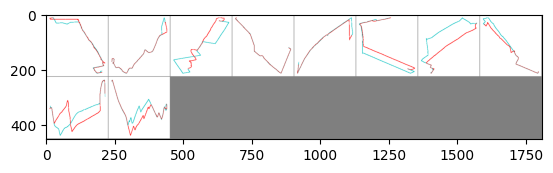

same  same  different same  same  different different different different different


In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes=tuple(labels_list)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

#Sono invertiti le label rispetto alle immmagini?
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(parameters['train_batch_size'])))

In [22]:
from ignite.engine import Engine, Events
from ignite.metrics import Loss, RunningAverage
from ignite.metrics import ConfusionMatrix
# from torch.utils.tensorboard import SummaryWriter
import pathlib
from torchvision import datasets, transforms
import torch
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
import os


def create_summary_writer(model, train_loader, log_dir, save_graph, device):
    """Creates a tensorboard summary writer

    Arguments:
        model {pytorch model}     -- the model whose graph needs to be saved
        train_loader {dataloader} -- the training dataloader
        log_dir {str}             -- the logging directory path
        save_graph {bool}         -- if True a graph is saved into the
                                     tensorboard log folder
        device {torch.device}     -- torch device object

    Returns:
        writer -- tensorboard SummaryWriter object
    """
    # writer = SummaryWriter(log_dir=log_dir)
    # if save_graph:
    #     images, labels = next(iter(train_loader))
    #     images = images.to(device)
    #     try:
    #         writer.add_graph(model, images)
    #     except Exception as e:
    #         print("Failed to save model graph: {}".format(e))
    # return writer

def train(model, optimizer, loss_fn, train_loader, val_loader,
          log_dir, device, epochs, log_interval,
          load_weight_path=None, save_graph=False):
    """Training logic for the wavelet model

    Arguments:
        model {pytorch model}       -- the model to be trained
        optimizer {torch optim}     -- optimiser to be used
        loss_fn                     -- loss_fn function
        train_loader {dataloader}   -- training dataloader
        val_loader {dataloader}     -- validation dataloader
        log_dir {str}               -- the log directory
        device {torch.device}       -- the device to be used e.g. cpu or cuda
        epochs {int}                -- the number of epochs
        log_interval {int}          -- the log interval for train batch loss

    Keyword Arguments:
        load_weight_path {str} -- Model weight path to be loaded (default: {None})
        save_graph {bool}      -- whether to save the model graph (default: {False})

    Returns:
        None
    """
    model.to(device)
    if load_weight_path is not None:
        model.load_state_dict(torch.load(load_weight_path))

    optimizer = optimizer(model.parameters())

    def process_function(engine, batch):
        model.train()
        optimizer.zero_grad()
        x, _ = batch
        x = x.to(device)
        print(x.size())
        y = model(x)
        loss = loss_fn(y, x)
        loss.backward()
        optimizer.step()
        return loss.item()

    def evaluate_function(engine, batch):
        model.eval()
        with torch.no_grad():
            x, _ = batch
            x = x.to(device)
            y = model(x)
            loss = loss_fn(y,x)
            return loss.item()

    # Questo oggetto contiene tutti i dati riguardanti il training
    trainer = Engine(process_function)
    # Questo oggetto contiene tutti i dati riguardanti la valutazione del modello. Ogni volta che viene chimato run su un determinato dataset 
    # il modello viene valutato. 
    # #Calcola la loss e segna ilnumero di epoche correnti, l'iterazione etc...
    evaluator = Engine(evaluate_function)

    RunningAverage(output_transform=lambda x:x).attach(trainer,'loss')
    RunningAverage(output_transform=lambda x:x).attach(evaluator,'loss')


    # writer = create_summary_writer(model, train_loader, log_dir,
    #                                save_graph, device)

    def score_function(engine):
        return -engine.state.metrics['loss']

    to_save = {'model': model}
    handler = Checkpoint(
        to_save,
        DiskSaver(os.path.join(log_dir, 'models'), create_dir=True),
        n_saved=5, filename_prefix='best', score_function=score_function,
        score_name="loss",
        global_step_transform=global_step_from_engine(trainer))

    evaluator.add_event_handler(Events.COMPLETED, handler)
    
    # Calcola la loss ogni "log_interval" iterazioni sul batch corrente. "log interval" di default vale 10.
    @trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
    def log_training_loss(engine):
        print(
            f"Epoch[{engine.state.epoch}] Iteration[{engine.state.iteration}/"
            f"{len(train_loader)}] Loss: {engine.state.output:.10f}"
        )
        # writer.add_scalar("training/loss", engine.state.output,
        #                   engine.state.iteration)

    # Calcola la loss su tutto il training set una volta che l'epoca è finita
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        avg_loss = metrics["loss"]
        print(
            f"Training Results - Epoch: {engine.state.epoch} Avg loss: {avg_loss:.10f}"
        )
        # writer.add_scalar("training/avg_loss", avg_loss, engine.state.epoch)

    # Calcola la loss su tutto il validation set una volta che l'epoca è finita
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        avg_loss = metrics["loss"]

        print(
            f"Validation Results - Epoch: {engine.state.epoch} Avg loss: {avg_loss:.10f}"
        )
        # writer.add_scalar("validation/avg_loss", avg_loss, engine.state.epoch)

    trainer.run(train_loader, max_epochs=epochs)

    # writer.close()

/home/lgiraldi/code/cabify/cabify_venv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


trainer

In [23]:
optimizer = Adam
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = F.mse_loss
model=SimpleCNNconvNet224()

# model.to(device)
# optimizer = optimizer(model.parameters())

In [24]:
train(model, optimizer, loss, train_loader,
          val_loader, parameters['log_dir'], device, parameters['epochs'],
          parameters['log_interval'],
          parameters['load_weight_path'], parameters['save_graph'])

torch.Size([10, 3, 224, 224])
dimensione di x fopo conv1: torch.Size([10, 64, 112, 112])
dimensione di x fopo conv2: torch.Size([10, 128, 56, 56])
dimensione di x fopo conv3: torch.Size([10, 256, 28, 28])


/tmp/ipykernel_148793/2000460018.py:72: UserWarning: Using a target size (torch.Size([10, 3, 224, 224])) that is different to the input size (torch.Size([10, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(y, x)
Current run is terminating due to exception: The size of tensor a (2) must match the size of tensor b (224) at non-singleton dimension 3
Engine run is terminating due to exception: The size of tensor a (2) must match the size of tensor b (224) at non-singleton dimension 3


dimensione di x fopo fc1: torch.Size([10, 4096])
dimensione di x fopo fc2: torch.Size([10, 1024])
dimensione di x fopo fc3: torch.Size([10, 2])


RuntimeError: The size of tensor a (2) must match the size of tensor b (224) at non-singleton dimension 3